In [19]:
import igraph as igraph
import networkx as nx
import matplotlib.pyplot as plt
import louvain
import time

def calculate_infomap(np_adj_list, method="infomap"):
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    t0=time.time()
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
#    labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
          
    print("Duración: {}s".format(time.time()-t0))
           
    return labels

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']

               
class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm



In [2]:
G=nx.read_gml("./dolphins.gml")

In [5]:
#a. Encuentre la partición en clusters de esta red utilizando la metodología Louvain, infomap, 
#fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

#Infomap
infomap_membership = calculate_infomap(nx.to_numpy_matrix(G))
infomap_dict = {str(i):v for i,v in enumerate(infomap_membership)}
fastgreedy_membership = calculate_infomap(nx.to_numpy_matrix(G), method='fastgreedy')
fastgreedy_dict = {str(i):v for i,v in enumerate(fastgreedy_membership)}

Duración: 0.005982875823974609s
Duración: 0.0010113716125488281s


In [7]:
nx.set_node_attributes(G,infomap_dict,'infomap')
nx.set_node_attributes(G,fastgreedy_dict,'fastgreedy')

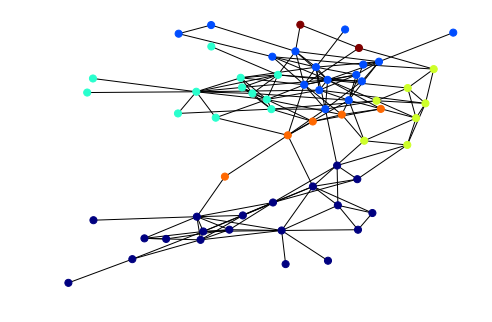

In [27]:
#Graficamos teniendo en cuenta los clusters (infomap)
nx.draw(G,node_size=50, node_color=infomap_membership, cmap = plt.get_cmap('jet'))

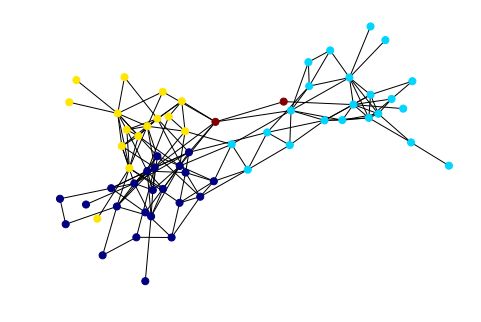

In [16]:
#Graficamos teniendo en cuenta los clusters (fastgreedy)
nx.draw(G,node_size=50, node_color=fastgreedy_membership, cmap = plt.get_cmap('jet'))

[3, 1, 3, 4, 2, 1, 1, 3, 4, 1, 3, 2, 0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 1, 2, 2, 1, 1, 1, 4, 2, 3, 1, 1, 0, 0, 2, 4, 0, 0, 4, 0, 1, 3, 0, 0, 2, 0, 3, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 0, 4, 1, 0]


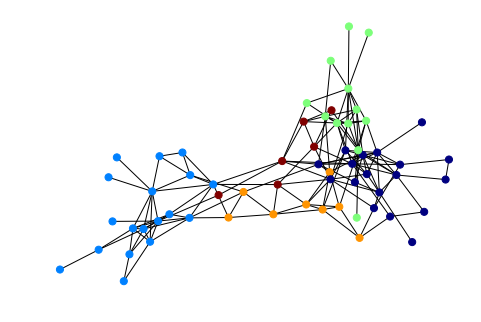

In [47]:
#Louvain
g = igraph.Graph.Weighted_Adjacency(nx.to_numpy_matrix(G).tolist(),mode=igraph.ADJ_UPPER)
parts = louvain.find_partition(g, louvain.ModularityVertexPartition)
parts=list(parts)
louvain_membership=list(range(len(G))) 
for k in range(len(parts)):
    for t in parts[k]:
        louvain_membership[t]=k
        
print(louvain_membership)
louvain_dict = {str(i):v for i,v in enumerate(louvain_membership)}
nx.set_node_attributes(G,infomap_dict,'louvain')
#Graficamos teniendo en cuenta los clusters (infomap)

nx.draw(G,node_size=50, node_color=louvain_membership, cmap = plt.get_cmap('jet'))

In [53]:
list(list(nx.algorithms.community.girvan_newman(G)))

[({'Beak',
   'Bumper',
   'CCL',
   'Cross',
   'Double',
   'Fish',
   'Five',
   'Fork',
   'Grin',
   'Haecksel',
   'Hook',
   'Jonah',
   'Kringel',
   'MN105',
   'MN60',
   'MN83',
   'Oscar',
   'PL',
   'Patchback',
   'SMN5',
   'SN100',
   'SN4',
   'SN63',
   'SN9',
   'SN96',
   'Scabs',
   'Shmuddel',
   'Stripes',
   'TR120',
   'TR77',
   'TR88',
   'TR99',
   'TSN103',
   'TSN83',
   'Thumper',
   'Topless',
   'Trigger',
   'Vau',
   'Whitetip',
   'Zap',
   'Zipfel'},
  {'Beescratch',
   'DN16',
   'DN21',
   'DN63',
   'Feather',
   'Gallatin',
   'Jet',
   'Knit',
   'MN23',
   'Mus',
   'Notch',
   'Number1',
   'Quasi',
   'Ripplefluke',
   'SN89',
   'SN90',
   'TR82',
   'Upbang',
   'Wave',
   'Web',
   'Zig'}),
 ({'Beak',
   'Bumper',
   'CCL',
   'Cross',
   'Double',
   'Fish',
   'Five',
   'Fork',
   'Grin',
   'Haecksel',
   'Hook',
   'Jonah',
   'Kringel',
   'MN105',
   'MN60',
   'MN83',
   'Oscar',
   'PL',
   'Patchback',
   'SMN5',
   'SN100',
  